# Data validation
- author: Haga, Chihiro
- date: 2024-04-05


## Initialization

In [23]:
import pandas as pd
from pyprojroot import here
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root_dir = here()
data_dir = root_dir / 'data'
output_dir = root_dir / 'output'
pq_dir = output_dir / 'pop-mesh-parquet'
csv_dir = output_dir / 'pop-mesh-csv'

## TEST01 column names
column names should be
['meshcode', 'F00-04', 'F05-09', 'F10-14', 'F15-19', 'F20-24', 'F25-29',
 'F30-34', 'F35-39', 'F40-44', 'F45-49', 'F50-54', 'F55-59', 'F60-64',
       'F65-69', 'F70-74', 'F75-79', 'F80-84', 'F85over', 'M00-04', 'M05-09',
       'M10-14', 'M15-19', 'M20-24', 'M25-29', 'M30-34', 'M35-39', 'M40-44',
       'M45-49', 'M50-54', 'M55-59', 'M60-64', 'M65-69', 'M70-74', 'M75-79',
       'M80-84', 'M85over', 'total']

In [3]:
columns_truth = ['meshcode', 'F00-04', 'F05-09', 'F10-14', 'F15-19', 'F20-24', 'F25-29',
                 'F30-34', 'F35-39', 'F40-44', 'F45-49', 'F50-54', 'F55-59', 'F60-64',
                 'F65-69', 'F70-74', 'F75-79', 'F80-84', 'F85over', 
                 'M00-04', 'M05-09', 'M10-14', 'M15-19', 'M20-24', 'M25-29', 
                 'M30-34', 'M35-39', 'M40-44', 'M45-49', 'M50-54', 'M55-59', 'M60-64', 
                 'M65-69', 'M70-74', 'M75-79', 'M80-84', 'M85over', 'total']
pq_names = list(pq_dir.glob('*.parquet'))
for pq_name in tqdm(pq_names):
    df = pd.read_parquet(pq_name)
    # compare column name with columns_truth
    assert df.columns.tolist() == columns_truth

  0%|          | 0/90 [00:00<?, ?it/s]

100%|██████████| 90/90 [00:04<00:00, 18.52it/s]


## Test 02. total should be total of all ages

In [4]:
eps = 1e-6
for pq_name in tqdm(pq_names):
    df = pd.read_parquet(pq_name).fillna(0)
    # assert if the total column is not the total of the other columns
    diff = df['total'] - df.iloc[:, 1:-1].sum(axis=1)
    # compare the diff with epsilon
    assert (diff.abs() < eps).all()

100%|██████████| 90/90 [00:10<00:00,  8.92it/s]


## Test 03. check the total population

In [21]:
ssp_total_pop_dfs = []
for pq_name in tqdm(pq_names):
    # identify ssp scenario and year
    ssp, year = pq_name.name.replace('.parquet', '').split('_')
    year = int(year)
    # read the parquet file and compute total by columns
    df = pd.read_parquet(pq_name).fillna(0)
    df = df.drop(['meshcode'], axis=1).sum()
    df = df.to_frame().T
    df['ssp'] = ssp
    df['year'] = year
    ssp_total_pop_dfs.append(df)

100%|██████████| 90/90 [00:08<00:00, 10.97it/s]


In [90]:
ssp_total_pop_df = pd.concat(ssp_total_pop_dfs)
# reorder ssp columun by characters
ssp_total_pop_df['ssp'] = pd.Categorical(ssp_total_pop_df['ssp'], categories=['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5'])
# make tidy data
ssp_total_pop_df = ssp_total_pop_df.melt(id_vars=['ssp', 'year'], var_name='cohort', value_name='population')
ssp_total_pop_df

,ssp,year,cohort,population
0,SSP4,2055,F00-04,1.120959e+06
1,SSP4,2045,F00-04,1.430233e+06
2,SSP3,2055,F00-04,8.344720e+05
3,SSP3,2045,F00-04,1.180002e+06
4,SSP1,2040,F00-04,2.114199e+06
...,...,...,...,...
3325,SSP4,2040,total,1.076437e+08
3326,SSP4,2050,total,9.719189e+07
3327,SSP2,2015,total,1.270947e+08
3328,SSP3,2040,total,1.049588e+08


<Axes: xlabel='year', ylabel='population'>

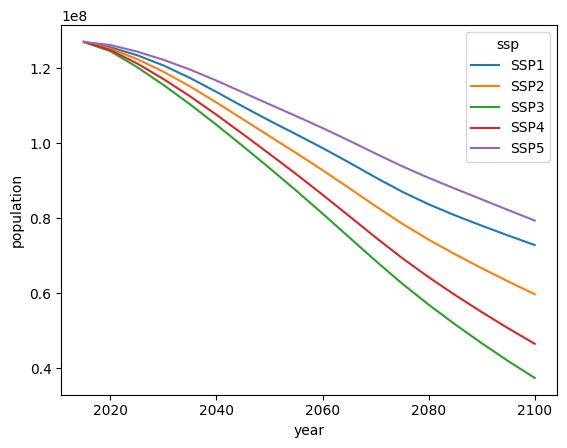

In [93]:
df = ssp_total_pop_df.query('cohort == "total"')
# plot lines by ssp scenario
sns.lineplot(data=df, x='year', y='population', hue='ssp')